In [19]:
import os

downloads_path = os.path.expanduser("~/Downloads")
os.chdir(downloads_path)

In [20]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

hvacdata = pd.read_csv('hvac_merged.csv')


/var/folders/9f/3yz89nb525nczbywh5dl11kh0000gn/T/ipykernel_32452/2688843383.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  hvacdata = pd.read_csv('hvac_merged.csv')


In [36]:
print(hvacdata.columns.tolist())

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


print(hvacdata.head(5))



['uic', 'job_seq', 'apl', 'cause_code', 'cdm_rin', 'csmp_narrative_summary', 'date_closing', 'date_maintenance_action', 'deferral_reason_code', 'due_date', 'eic', 'equipment_nomenclature', 'eswbs_opening', 'iuc_screening_code', 'location', 'mhc', 'mho', 'mhr', 'priority_code', 'safety_code', 'status_code', 'tycom_screening_code', 'type_availability_code', 'type_of_maintenance_action', 'when_discovered_code', 'work_center', 'total_ima_man_hours', 'total_ship_force_man_hours', 'total_replacement_cost', 'total_repair_replacement_cost', 'def_narrative', 'nondef_narrative', 'closing_narrative', 'ima_narrative', 'total_material_cost', 'opening_ship_system', 'job_status', 'days_open', 'action_taken', 'intermediate_unit_commander_screening', 'priority', 'type_of_availability_needed', 'tycom_screening', 'when_discovered', 'cause', 'deferral_reason', 'feasible_with_ship_inventory', 'feasible_with_additional_dla_inventory', 'ship', 'uic_s', 'jsn', 'date_closing_s', 'demand_date', 'issue_date', 'c

In [22]:


hvacdata['date_maintenance_action'] = pd.to_datetime(hvacdata['date_maintenance_action'], errors='coerce')

# group by `ship` to find the earliest date
rcoh_start_dates = (
    hvacdata.groupby('ship')['date_maintenance_action']
    .min()
    .reset_index()
    .rename(columns={'date_maintenance_action': 'rcoh_start_date'})
)

print(rcoh_start_dates)



# !!!!! RCOH for CVN 68 took place between 1998 and 2001, but the first maintenace job recorded in the dataset for CVN 68 is in 2017?
# Just use start dates within the data? This may not accurately represent the true project phases

     ship rcoh_start_date
0   CVN68      2017-11-02
1   CVN69      2017-11-01
2   CVN70      2017-11-01
3   CVN71      2017-11-04
4   CVN72      2017-11-01
5   CVN73      2017-11-02
6   CVN74      2017-11-01
7   CVN75      2017-11-02
8   CVN76      2017-11-01
9   CVN77      2017-11-01
10  CVN78      2017-11-01


In [23]:
hvacdata = hvacdata.merge(rcoh_start_dates, on='ship', how='left')


In [45]:
# calculate time since RCOH start of maintenance jobs

hvacdata['months_since_rcoh_start'] = (
    (hvacdata['date_maintenance_action'] - hvacdata['rcoh_start_date']) / np.timedelta64(1, 'M')
).astype(int)


In [25]:
print(hvacdata[['ship', 'date_maintenance_action', 'rcoh_start_date', 'months_since_rcoh_start']].head())

    ship date_maintenance_action rcoh_start_date  months_since_rcoh_start
0  CVN69              2018-07-16      2017-11-01                        8
1  CVN69              2018-07-16      2017-11-01                        8
2  CVN77              2018-07-16      2017-11-01                        8
3  CVN75              2018-05-11      2017-11-02                        6
4  CVN75              2018-05-11      2017-11-02                        6


In [31]:
job_summary = (
    hvacdata.groupby(['ship', 'months_since_rcoh_start'])
    .agg(
        num_jobs=('ship', 'count'),
        totMaterialCost=('totMaterialCost', 'sum')
    )
    .reset_index()
)

print(job_summary.head(10))


    ship  months_since_rcoh_start  num_jobs  totMaterialCost
0  CVN68                        0       109          3510.49
1  CVN68                        1        23          4342.57
2  CVN68                        2       268         60903.65
3  CVN68                        3       119          8226.57
4  CVN68                        4        68          1608.14
5  CVN68                        5       165          9679.50
6  CVN68                        6        64         26928.51
7  CVN68                        7       107         32103.26
8  CVN68                        8        27           597.35
9  CVN68                        9        61          8536.91


In [35]:
hvacdata['computed_totMaterialCost'] = hvacdata['unit_price'] * hvacdata['quantity']

# compare with the original
print(hvacdata[['totMaterialCost', 'computed_totMaterialCost']].head(10))


   totMaterialCost  computed_totMaterialCost
0            50.92                     50.92
1            10.35                     10.35
2            10.35                     10.35
3           249.98                     20.00
4           249.98                     16.00
5           249.98                     20.00
6           249.98                    160.98
7           249.98                     17.00
8           249.98                     16.00
9           363.59                    363.59


In [46]:
# groups data by ship, months_since_rcoh_start, and part


monthly_part_summary = (
    hvacdata.groupby(['ship', 'months_since_rcoh_start', 'niin_nomenclature'])
    .agg(
        total_part_quantity=('quantity', 'sum'),
        num_jobs=('job_status', 'count'),
        total_material_cost=('totMaterialCost', 'sum')
    )
    .reset_index()
)

print(monthly_part_summary.head(20))


     ship  months_since_rcoh_start    niin_nomenclature  total_part_quantity  \
0   CVN68                        0               BELT,V                  4.0   
1   CVN68                        0   CONTACTOR,MAGNETIC                  1.0   
2   CVN68                        0   FILTER ELEMENT,AIR                 80.0   
3   CVN68                        0  RELAY,ELECTROMAGNET                  1.0   
4   CVN68                        1   FILTER ELEMENT,AIR                  6.0   
5   CVN68                        1  HEATING ELEMENT,ELE                  3.0   
6   CVN68                        1   PARTS KIT,PRESSURE                  1.0   
7   CVN68                        1  PARTS KIT,REGULATIN                  1.0   
8   CVN68                        1  RELAY,ELECTROMAGNET                  1.0   
9   CVN68                        1                 RING                  2.0   
10  CVN68                        1       RING,RETAINING                  2.0   
11  CVN68                        1    TR

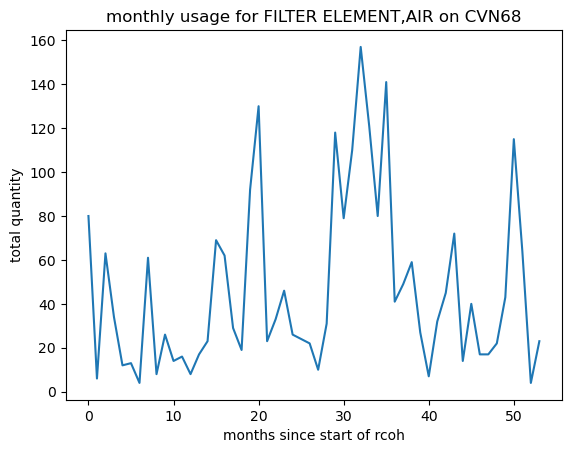

In [43]:
import matplotlib.pyplot as plt

part = 'FILTER ELEMENT,AIR'
ship = 'CVN68'

part_data = monthly_part_summary[
    (monthly_part_summary['niin_nomenclature'] == part) &
    (monthly_part_summary['ship'] == ship)
]

plt.plot(part_data['months_since_rcoh_start'], part_data['total_quantity'])
plt.title(f"monthly usage for {part} on {ship}")
plt.xlabel('months since start of rcoh')
plt.ylabel('total quantity')
plt.show()


In [47]:
# some feature ideas that could go into model: num_jobs (more jobs = more parts), maintenace_duration (if jobs are taking longer, maybe more parts are needed), ship_age (older ships may need more replacement parts), months_since_rcoh_start, etc.